# 2 methods shall be implemented to forecast taxi demand:

1) Time Series Forecasting using ARIMA

2) Machine Learning method (RandomForest Predictor and XGBoost Predictor)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
import re

pd.set_option('display.max_columns', None)

#arima
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA

#machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

#model
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Which Zone are we forecasting for? 

In [18]:
target_zone = "Midtown Center"

# import files

In [30]:
df = pd.read_csv("./tripdata.csv", parse_dates=True)

In [31]:
zone = pd.read_csv("./taxi_zone_lookup.csv")

# study the file

In [32]:
df['tpep_pickup_datetime']= pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime']= pd.to_datetime(df['tpep_dropoff_datetime'])

In [33]:
df.isna().sum()

Unnamed: 0               0
VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

In [34]:
print("the earliest record is: " + str(min(df["tpep_pickup_datetime"])) 
      +"\n while the latest record is: " + str(max(df["tpep_pickup_datetime"])))

the earliest record is: 2017-01-01 00:00:00
 while the latest record is: 2017-01-07 23:59:59


# join all the dataset

In [35]:
df = pd.merge(df,zone,left_on="PULocationID", right_on="LocationID")

In [36]:
df.columns

Index(['Unnamed: 0', 'VendorID', 'tpep_pickup_datetime',
       'tpep_dropoff_datetime', 'passenger_count', 'trip_distance',
       'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount', 'LocationID',
       'Borough', 'Zone', 'service_zone'],
      dtype='object')

In [37]:
#tdfrim dataset
df = df[['Unnamed: 0', 'tpep_pickup_datetime', 'Zone']]

In [38]:
#rename columns
df.columns = ['trip_id', 'pickup_datetime', 'Zone']

# Technique 1: Machine Learning

In [65]:
df_ml = df.copy(deep=True)

## aggregate count

In [66]:
target_zone

'Midtown Center'

In [67]:
df_ml = df_ml[df_ml["Zone"]==target_zone]
df_ml = pd.DataFrame(df_ml.resample('H', on='pickup_datetime').trip_id.count())


In [68]:
df_ml = df_ml.reset_index()

In [69]:
df_ml.head()

,pickup_datetime,trip_id
0,2017-01-01 00:00:00,653
1,2017-01-01 01:00:00,596
2,2017-01-01 02:00:00,405
3,2017-01-01 03:00:00,286
4,2017-01-01 04:00:00,174


## Feature engineering

In [70]:
# create weekday/weekend column
df_ml["weekday"] = df_ml["pickup_datetime"].dt.weekday

def week_day_end(value):
    if value > 5:
        return "weekend"
    else:
        return "weekday"
    
df_ml["weekday"] = df_ml["weekday"].apply(week_day_end)

In [71]:
#create hour columns
df_ml["hour"] = df_ml["pickup_datetime"].dt.hour
df_ml.drop("pickup_datetime", axis="columns", inplace=True)

In [72]:
#keep essential columns for ML
df_ml.columns = ['trips', 'weekday', 'hour']

## resample to create more instances

In [73]:
df_ml = df_ml.sample(n=(len(df_ml)*5),replace=True)
df_ml.shape

(840, 3)

## data preprocessing

In [75]:
#dummy variable
df_ml = pd.get_dummies(df_ml)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(df_ml.drop("trips", axis="columns"), df_ml["trips"], 
                                                    test_size = 0.2, random_state = 42)

## ML Model 1: Random Forest (81.5% tuned to 84.9% untuned R2 Score)

### untuned

In [116]:
rf_regressor = RandomForestRegressor(n_estimators = 201, random_state=42)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(n_estimators=201, random_state=42)

In [117]:
rf_regressor.score(X_test,y_test)

0.8491891444149521

### hypertuned

In [118]:
param_grid = { 
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [4,5,10,15,20],
    "min_samples_split" : [4,5,10,20,50],
    "min_samples_leaf" : [4,5,10,20,50]}

In [119]:
tuned_RF = GridSearchCV(estimator = rf_regressor,
                        param_grid = param_grid,
                        cv = 10,
                        scoring="r2",
                        n_jobs = -1)


In [120]:
tuned_RF.fit(X_train, y_train)
best_accuracy = tuned_RF.best_score_
best_parameters = tuned_RF.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 81.54 %
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4}


## ML Model 2: XGBoost (85.0% R2 Score)

### untuned

In [122]:
xgbreg = XGBRegressor(random_state=42)
xgbreg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [123]:
xgbreg.score(X_test,y_test)

0.8495700780444607

# Technique 2: ARIMA time series forecasting 
* statsmodel is package is under going statespace framework reconstruction. Some functions might not be available

## keep only transaction for interested zone

In [14]:
df_arima = df.copy(deep=True)


In [18]:
df_arima = df_arima[df_arima["Zone"]==zone]

## group transaction at regular interval (hourly)

In [19]:
df_arima = pd.DataFrame(df_arima.resample('H', on='pickup_datetime').trip_id.count())

## display tempo

<AxesSubplot:xlabel='pickup_datetime'>

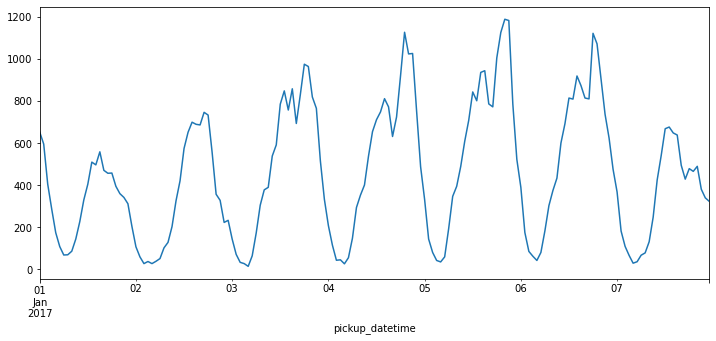

In [20]:
df_arima["trip_id"].plot(figsize= (12,5))

## check for stationarity

In [21]:
print("P_value is: " + str(adfuller(df_arima, autolag="AIC")[1]))

P_value is: 2.389634528891065e-07


## find out order of ARIMA

In [22]:
warnings.filterwarnings("ignore")

In [23]:
#fit the arima model
stepwise_fit = auto_arima(df_arima["trip_id"],suppress_warnings=True)

#extract best p,d,q value using regular expression
summary_string = str(stepwise_fit.summary())
param = re.findall('SARIMAX\(([0-9]+), ([0-9]+), ([0-9]+)',summary_string)
p,d,q = int(param[0][0]) , int(param[0][1]) , int(param[0][2])
print(p,d,q)

3 0 1


## split train and test data

In [24]:
train_stop = int(round(0.8*len(df_arima)))
train =  df_arima.iloc[:train_stop]
test = df_arima.iloc[train_stop:]
print(train.shape, test.shape)

(134, 1) (34, 1)


## train data

In [ ]:
model = ARIMA(train["trip_id"], order=(p,d,q))
model = model.fit

## make prediction on test data

In [84]:
start = len(train)
end = len(train) + len(test) -1

In [ ]:
pred = model.predict(start=start, end = end, type="levels")

## make prediction for the next 7 days 

In [ ]:
model2 = ARIMA(df_arima["trip_id"], order=(p,d,q))
model2 = model.fit

In [88]:
future_index = pd.date_range(start= "1/8/2017 00:00:00",end="01/14/2017 23:00:00", freq="H")`

In [ ]:
pred2 = model2.predict(start=len(df_arima), end=(len(df_arima)+len(future_index)), type=levels)
pred2.index = future_index